In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import ClassificationDNN
from bbb.models.bnn import ClassificationBNN
from bbb.data import load_mnist, load_adverserial_mnist
from bbb.models.layers import BaseBFC

from evaluate_classifier import evaluate_classifier

from model_details import MODEL_DETAILS_DICT, load_model

from labellines import labelLines

In [2]:
matplotlib.style.use('default')
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [4]:
MODEL = "bnn_sgp_600_1200"
MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]
net, params = load_model(MODEL)

MODEL_DETAILS

2022-03-30 01:12:42,629 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:42,629 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:42,640 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:42,640 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:42,642 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:42,642 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


ModelDetails(dir='../saved_models/BBB_classification/baseline/single_gaussian_prior/600_epochs/1200/2022-03-27-20.30.22', mclass=<class 'bbb.models.bnn.ClassificationBNN'>, description='BNN - 1200 hidden units, SGP, 600 epochs')

In [5]:
# Load data
path = "../data/adversarial_mnist/"
data = {}
eps = [0, 0.05, 0.1, 0.25]
for e in eps:
    data[e] = load_adverserial_mnist(train=False, size=8*params.batch_size, batch_size=params.batch_size, shuffle=True, randomise=True, epsilon=e)

In [13]:
# net = MODEL_DETAILS.mclass(params=params, eval_mode=True).to(DEVICE)
net = MODEL_DETAILS.mclass(params=params, eval_mode=True)
net.model.load_state_dict(torch.load(os.path.join(MODEL_DETAILS.dir, 'model.pt'), map_location=torch.device('cpu')))

2022-03-28 13:43:04,292 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,292 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,302 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,302 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,303 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-28 13:43:04,303 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


<All keys matched successfully>

In [6]:
results = {}

for MODEL in MODEL_DETAILS_DICT.keys():
    results[MODEL] = {}
    
for MODEL in MODEL_DETAILS_DICT.keys():
    print(f"-- {MODEL} --")
    net, params = load_model(MODEL)

    results[MODEL]['scores'] = []

    for eps in data.keys():
        eval_dict = evaluate_classifier(net, data[eps])
        
        score = float(eval_dict['eval_score'].numpy())
        eval_dict['eval_score'] = score 
        results[MODEL]['scores'].append(score)
        
        print(f"Eps {eps:<03.2f}: \t{round(eval_dict['eval_score'],4):>3}")

        results[MODEL][eps] = eval_dict

2022-03-30 01:12:59,385 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:59,385 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:59,396 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:59,396 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:59,397 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:12:59,397 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


-- bnn_sgp_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9727
Eps 0.10: 	0.7998


2022-03-30 01:13:18,491 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:18,491 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:18,496 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:18,496 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:18,497 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:18,498 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


Eps 0.25: 	0.0742
-- bnn_sgp_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9736
Eps 0.10: 	0.7686


2022-03-30 01:13:30,315 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:30,315 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:30,317 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:30,317 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:30,318 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:30,318 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


Eps 0.25: 	0.0547
-- bnn_sgp_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9727
Eps 0.10: 	0.7617


2022-03-30 01:13:35,654 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:35,654 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:35,664 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:35,664 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:35,665 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:35,665 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


Eps 0.25: 	0.0586
-- bnn_sgp_600_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9854
Eps 0.10: 	0.8418


2022-03-30 01:13:54,954 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:54,954 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:54,959 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:54,959 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:54,960 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:13:54,960 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


Eps 0.25: 	0.1113
-- bnn_sgp_600_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9814
Eps 0.10: 	0.8271


2022-03-30 01:14:06,823 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:14:06,824 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:14:06,825 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:14:06,825 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:14:06,826 - bbb.models.layers - INFO - Weights Prior: Gaussian with mean 0 and variance 1.0
2022-03-30 01:14:06,828 - bbb.models.layers - INFO - Biases Prior: Gaussian with mean 0 and variance 1.0


Eps 0.25: 	0.1094
-- bnn_sgp_600_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9814
Eps 0.10: 	0.8281


2022-03-30 01:14:12,018 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:12,018 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:12,028 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:12,029 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:12,030 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:12,030 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.0986
-- bnn_mog_600_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9766
Eps 0.10: 	0.8271


2022-03-30 01:14:40,510 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:40,510 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:40,516 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:40,516 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:40,518 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:40,518 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.1006
-- bnn_mog_600_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9785
Eps 0.10: 	0.8359


2022-03-30 01:14:58,909 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:58,909 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:58,911 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:58,911 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:58,912 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:14:58,913 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.0996
-- bnn_mog_600_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9785
Eps 0.10: 	0.8398


2022-03-30 01:15:07,756 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:07,756 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:07,766 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:07,766 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:07,768 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:07,768 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.1045
-- bnn_mog_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9883
Eps 0.10: 	0.792


2022-03-30 01:15:36,313 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:36,314 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:36,319 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:36,319 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:36,320 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:36,321 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.0791
-- bnn_mog_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9707
Eps 0.10: 	0.7441


2022-03-30 01:15:54,508 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:54,508 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:54,511 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:54,511 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:54,512 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5
2022-03-30 01:15:54,512 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0009118819655545162) and weight 0.5


Eps 0.25: 	0.0537
-- bnn_mog_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9795
Eps 0.10: 	0.7939
Eps 0.25: 	0.083
-- dnn_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.8643
Eps 0.10: 	0.46
Eps 0.25: 	0.0127
-- dnn_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.8262
Eps 0.10: 	0.3818
Eps 0.25: 	0.0068
-- dnn_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.7979
Eps 0.10: 	0.3662
Eps 0.25: 	0.0088
-- dnn_600_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.8818
Eps 0.10: 	0.4795
Eps 0.25: 	0.0107
-- dnn_do_400 --
Eps 0.00: 	1.0
Eps 0.05: 	0.916
Eps 0.10: 	0.541
Eps 0.25: 	0.0117
-- dnn_do_800 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9092
Eps 0.10: 	0.499
Eps 0.25: 	0.0117
-- dnn_do_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.873
Eps 0.10: 	0.4414
Eps 0.25: 	0.0088
-- dnn_do_600_1200 --
Eps 0.00: 	1.0
Eps 0.05: 	0.9365
Eps 0.10: 	0.5723
Eps 0.25: 	0.0186


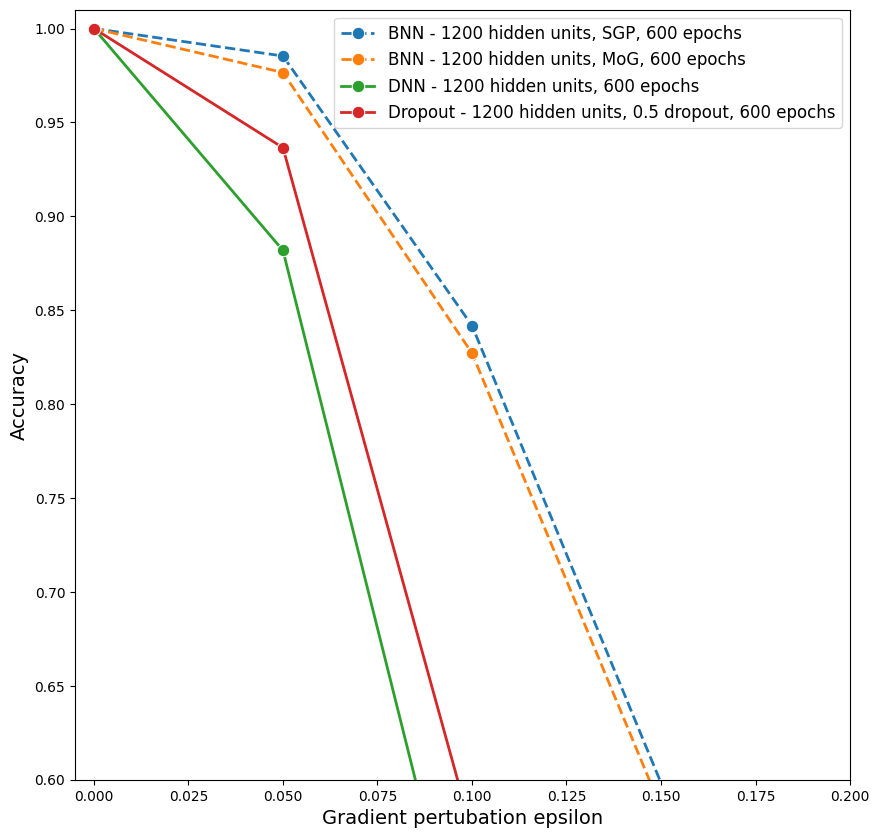

In [15]:
save_dir = "../plots/classification/adversarial"
labels = [0, 0.05, 0.1, 0.25]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
lw = 2
num_hidden_units = 1200
for idx, model in enumerate([x for x in results.keys() if x.__contains__(str(num_hidden_units)) and x.__contains__("600")]):

    description = MODEL_DETAILS_DICT[model].description
    scores = results[model]['scores']

    lw = 2
    ms = 9

    if model.__contains__("bnn"):
        sns.lineplot(y=scores, x=labels, label=f"{description}", ax=ax, color=colors[idx],linestyle='--', linewidth=lw, marker="o", markersize=ms)
    else:
        sns.lineplot(y=scores, x=labels, label=f"{description}", ax=ax, color=colors[idx],linewidth=lw, marker="o", markersize=ms)

ax.legend()
ax.set_xlabel('Gradient pertubation epsilon', fontsize=14)
ax.set(ylim=(0.60, 1.01), xlim=(-0.005, 0.20))
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(loc='upper right', prop={'size': 12})


plt.savefig(os.path.join(save_dir, f'accuracy_eps_600_{num_hidden_units}_hidden_units_plot.png'), pad_inches=0.2, bbox_inches='tight')

plt.show()